In [17]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

In [18]:
transform = transforms.Compose([
    # 1. Normalize each pixel value from [0, 255] to [0.0, 1.0]
    # 2. Reorders dimensions from (H, W, C) to (C, H, W)
    transforms.ToTensor(),
    # Normalize each pixel value from [0.0, 1.0] to [-1.0, 1.0]
    # Because CNNs work better when inputs are centered around 0 instead of [0, 1]
    # Especially with activations like tanh, which outputs values in [-1, 1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 4

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

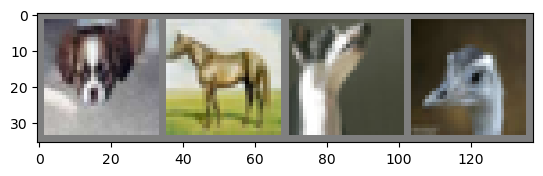

dog   horse dog   bird 


In [19]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f"{classes[labels[j]]:5s}" for j in range(batch_size)))

In [20]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten all dimensions except batch
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [21]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [22]:
for epoch in range(2):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader, 0):
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f"[{epoch + 1}, {i + 1:5d} loss: {running_loss / 2000:.3f}]")
            running_loss = 0.0

print("Finished Training")

[1,  2000 loss: 2.181]
[1,  4000 loss: 1.843]
[1,  6000 loss: 1.697]
[1,  8000 loss: 1.606]
[1, 10000 loss: 1.547]
[1, 12000 loss: 1.489]
[2,  2000 loss: 1.432]
[2,  4000 loss: 1.417]
[2,  6000 loss: 1.386]
[2,  8000 loss: 1.357]
[2, 10000 loss: 1.350]
[2, 12000 loss: 1.352]
Finished Training


In [23]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

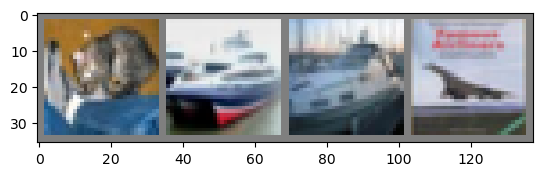

Ground truth:  cat   ship  ship  plane


In [24]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Print images
imshow(torchvision.utils.make_grid(images))
print('Ground truth: ', ' '.join(f"{classes[labels[j]]:5s}" for j in range(4)))

In [25]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [26]:
outputs = net(images)

In [27]:
_, predicted = torch.max(outputs, 1)

print("Predicted: ", ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  cat   ship  ship  plane


In [28]:
correct = 0
total = 0

print_log = True

net.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = net(images)
        _, predicted = torch.max(outputs, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the 10000 test images: {correct / total:%}")

Accuracy of the network on the 10000 test images: 53.150000%


In [29]:
# Count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

net.eval()
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, dim=1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = float(correct_count) / total_pred[classname]
    print(f"Accuracy for class: {classname:5s} is {accuracy:.2%}")

Accuracy for class: plane is 50.80%
Accuracy for class: car   is 71.20%
Accuracy for class: bird  is 26.60%
Accuracy for class: cat   is 31.90%
Accuracy for class: deer  is 46.70%
Accuracy for class: dog   is 56.30%
Accuracy for class: frog  is 76.90%
Accuracy for class: horse is 48.70%
Accuracy for class: ship  is 72.10%
Accuracy for class: truck is 50.30%


## Train on GPU

In [30]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [31]:
# Recursively go over all modules and convert their parameters and buffers to CUDA tensors.
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [32]:
# Needs to send the inputs and targets at every step to GPU
inputs, labels = data[0].to(device), data[1].to(device)